In [109]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from google.colab import drive
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


PATH_TO_DATA = "/content/drive/MyDrive/Colab Notebooks/churn.csv"
drive.mount('/content/drive')
df = pd.read_csv(PATH_TO_DATA,index_col=0)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [110]:
#Feature engineering
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/churn.csv",index_col=0)

df = df.drop("Surname",axis=1) #Identifiers likely not relevant in predict churn
df = df.drop("CustomerId",axis=1)
df["Gender"] =df["Gender"].replace({"Female":0,"Male":1}) # Convert gender to numbers
df["Geography"] = df["Geography"].replace({"France":0,"Spain":1,"Germany":2})
bins = [300, 579, 669, 739, 799, 850] # Based on the FICO system, ranks credit ranks scores based on these bins from 'Poor' to 'Excellent'
labels = range(len(bins))[:-1]
df["CreditScore"] = pd.cut(df["CreditScore"],bins=bins,labels=labels)
df["Tenure_Age"] = df["Tenure"]/df["Age"] # Raise the complexity by creating an additional column compose of previous ones

max_age = df["Age"].max()   #Noramlization
max_balance = df["Balance"].max()
max_salary = df["EstimatedSalary"].max()
df["Age"] = df["Age"]/max_age
df["Balance"] = df["Balance"]/max_balance
df["EstimatedSalary"] = df["EstimatedSalary"]/max_salary


<ipython-input-110-9c630f0004e7>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Gender"] =df["Gender"].replace({"Female":0,"Male":1}) # Convert gender to numbers
<ipython-input-110-9c630f0004e7>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Geography"] = df["Geography"].replace({"France":0,"Spain":1,"Germany":2})


In [111]:
seed = 1
weights = [30,10,10,50] # Weights of each evaluation metric in the order [Accuracy,Precision,Recall,F1]
features = df.drop("Exited",axis=1)
labels = df["Exited"]

best_model = {"Decision Tree":None, "Logistic Regression": None,"Nearest Neighbor": None}
ft_train,ft_test,label_train,label_test = train_test_split(features,labels,test_size=.25,random_state=seed)
def calculated_weighted_sum(evaluation_metrics):
  s = 0
  for u,v in zip(evaluation_metrics,weights):
    s+= u*v
  return s
def compute_eval_metrics(tn,fp,fn,tp):
    curr_accuracy = (tn+tp)/(tn+fp+fn+tp) if tn+fp+fn+tp != 0 else 0
    curr_precision = (tp/(tp+fp)) if (tp+fp) != 0 else 0
    curr_recall = (tp/(tp+fn)) if (tp+fn) != 0 else 0
    curr_f1 = 2*((curr_precision*curr_recall)/(curr_precision+curr_recall))
    return [curr_accuracy,curr_precision,curr_recall,curr_f1]

def best_decision_tree(sd):
  best = None
  best_sum = 0
  accuracy = precision = recall = f1 = 0
  for depth in [5,10,20,None]:
    for split in [2,5,10,100,1000]:
      for max_leaf in [5,10,20,100,1000,None]:
        candidate = DecisionTreeClassifier(random_state=sd,max_depth=depth,min_samples_split=split,max_leaf_nodes=max_leaf)
        candidate.fit(ft_train,label_train)
        predictions = candidate.predict(ft_test)
        matrix = confusion_matrix(predictions,label_test)
        tn,fp,fn,tp = matrix.ravel()
        metrics = compute_eval_metrics(tn,fp,fn,tp)
        # print("tree",metrics[0])

        result = calculated_weighted_sum(metrics)
        if result > best_sum:
          best_sum = result
          best = candidate
    return (best,best_sum)

def best_logistic(sd):
  best = None
  best_sum = 0
  accuracy = precision = recall = f1 = 0
  for reg in [.1,10,100,]:
    for i in [300,400,700,1000]:
      candidate = LogisticRegression(random_state=sd,C=reg,max_iter=i)
      candidate.fit(ft_train,label_train)
      predictions = candidate.predict(ft_test)
      matrix = confusion_matrix(predictions,label_test)
      tn,fp,fn,tp = matrix.ravel()
      metrics = compute_eval_metrics(tn,fp,fn,tp)
      result = calculated_weighted_sum(metrics)
      # print("reg",metrics[0])

      if result > best_sum:
        best_sum = result
        best = candidate
  return (best,best_sum)


def best_knn():
  best = None
  best_sum = 0
  accuracy = precision = recall = f1 = 0
  for n in [1,5,9,20]:
    for kind in ["uniform","distance"]:
      for distance_type in ["euclidean","manhattan"]:
        candidate = KNeighborsClassifier(n_neighbors=n,weights=kind,metric=distance_type)
        candidate.fit(ft_train,label_train)
        predictions = candidate.predict(ft_test)
        matrix = confusion_matrix(predictions,label_test)
        tn,fp,fn,tp = matrix.ravel()
        metrics = compute_eval_metrics(tn,fp,fn,tp)
        result = calculated_weighted_sum(metrics)
        # print("Knn",metrics[0])
        if result > best_sum:
          best_sum = result
          best = candidate
  return (best,best_sum)

def find_best_model_per_class(models,sd):
  for k,v in models.items():
    if k == "Decision Tree":
      bm,sum = best_decision_tree(sd)
      models[k] = best_decision_tree(sd)
    elif k == "Logistic Regression":
      bm,sum = best_logistic(sd)
      models[k] = best_logistic(sd)
    else:
      bm,sum =  best_knn()
      models[k] = best_knn()
soln = []
winner_type =[]
def find_winner(models):
  winner = None
  best_acc = 0
  for k,v in models.items():
      model,sum = v
      kfold = KFold(n_splits=12)
      accuraccies = cross_val_score(model,features,labels,cv=kfold)
      curr_acc = accuraccies.mean()
      soln.append((curr_acc,k))
      if curr_acc > best_acc:
        best_acc = curr_acc
        winner = model
  winner_type.append(winner)
  return winner

find_best_model_per_class(best_model,seed)
#Should be a decision tree

tree = find_winner(best_model)



# for k,v in best_model.items():
#   kfold = KFold(n_splits=12)
#   accuraccies = cross_val_score(v,features,labels,cv=kfold)
#   print(k,accuraccies.mean())


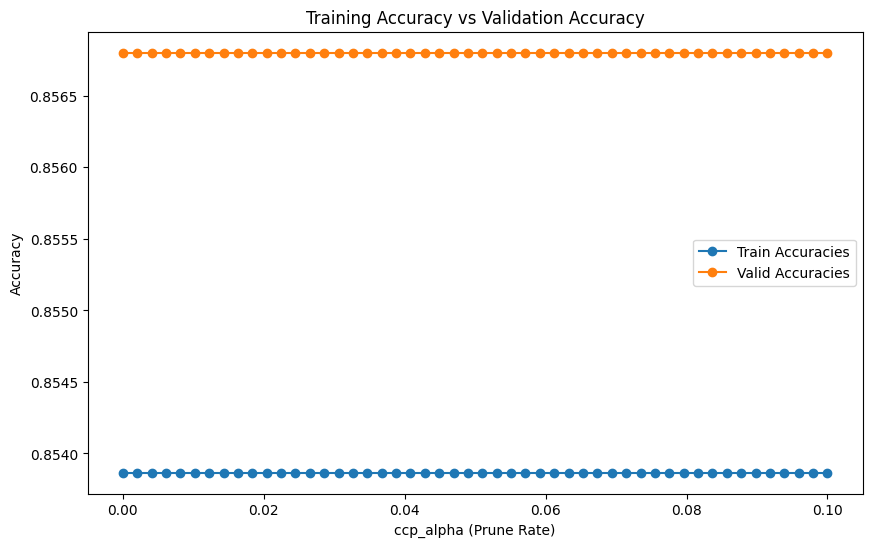

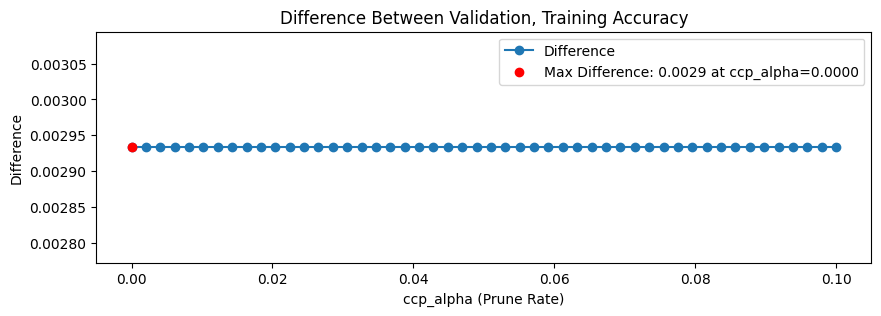

In [112]:
#Optimize the winner further using pruning
def find_val_train_diff(model):
  train_predictions = model.predict(ft_train)
  train_accuracy = accuracy_score(label_train, train_predictions)
  predictions = model.predict(ft_test)
  valid_acuracy = accuracy_score(predictions,label_test)
  diff = valid_acuracy - train_accuracy
  soln = (diff,train_accuracy,valid_acuracy)
  return soln

train_accuracy = []
valid_acuracy = []
best_rate = 0
best_diff = []
options = np.linspace(0, 0.1, 50)
for prune_rate in options:
  tree.set_params(ccp_alpha=prune_rate)
  stats = find_val_train_diff(tree)
  best_diff.append(stats[0])
  train_accuracy.append(stats[1])
  valid_acuracy.append(stats[2])
diff = [v-t for (v,t) in zip(valid_acuracy,train_accuracy)]
plt.figure(figsize=(10, 6))
plt.plot(options,train_accuracy,'o-',label="Train Accuracies")

plt.plot(options,valid_acuracy,'o-',label="Valid Accuracies")
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel("ccp_alpha (Prune Rate)")
plt.ylabel("Accuracy")
plt.legend(loc='best')


plt.figure(figsize=(10,3))
plt.title('Difference Between Validation, Training Accuracy')
plt.plot(options,diff,'o-',label="Difference")
plt.scatter(np.argmax(diff), diff[np.argmax(diff)], color='red', label=f"Max Difference: {diff[np.argmax(diff)]:.4f} at ccp_alpha={options[np.argmax(diff)]:.4f}", zorder=5)
plt.xlabel("ccp_alpha (Prune Rate)")
plt.ylabel("Difference")
plt.legend(loc='best')

plt.show()


{'Decision Tree': (DecisionTreeClassifier(ccp_alpha=0.1, max_depth=5, max_leaf_nodes=10,
                       random_state=1), 66.23474341117819), 'Logistic Regression': (LogisticRegression(C=100, max_iter=300, random_state=1), 50.142788281724705), 'Nearest Neighbor': (KNeighborsClassifier(metric='euclidean', n_neighbors=1), 48.32236414670742)}
{'Decision Tree': (array([[1907,  285],
       [  73,  235]]), [0.8568, 0.4519230769230769, 0.762987012987013, 0.5676328502415459]), 'Logistic Regression': (array([[1923,  404],
       [  57,  116]]), [0.8156, 0.2230769230769231, 0.6705202312138728, 0.33477633477633484]), 'Nearest Neighbor': (array([[1720,  346],
       [ 260,  174]]), [0.7576, 0.3346153846153846, 0.4009216589861751, 0.36477987421383645])}


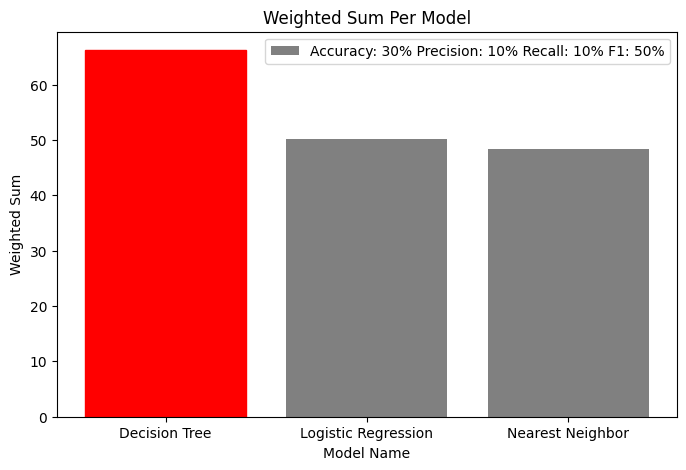

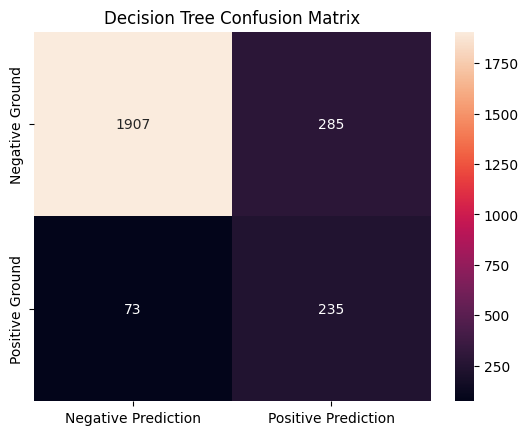

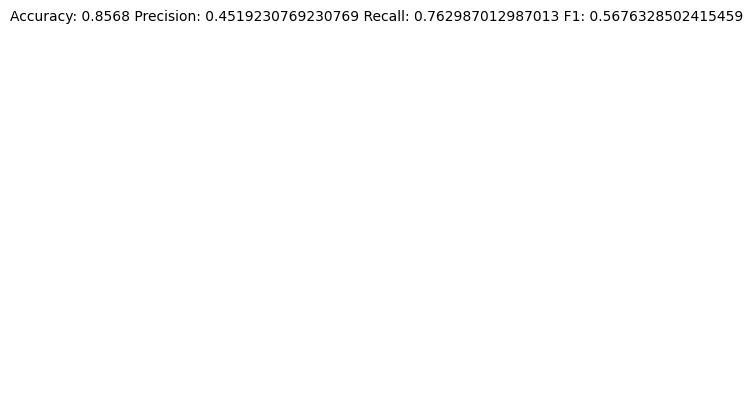

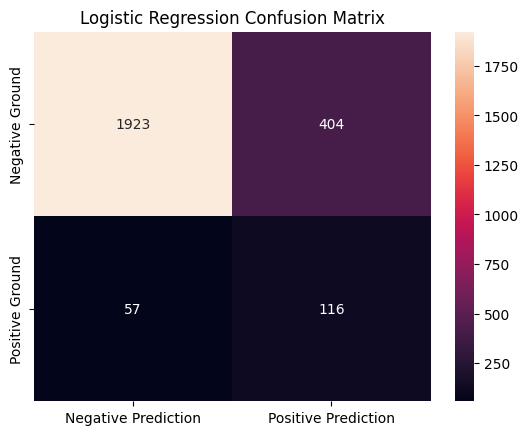

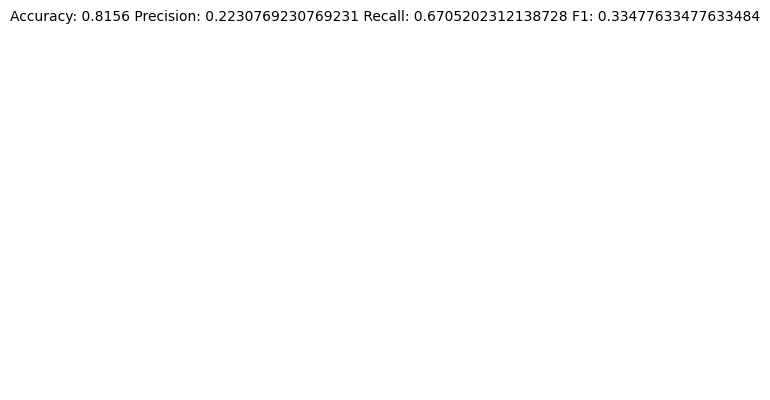

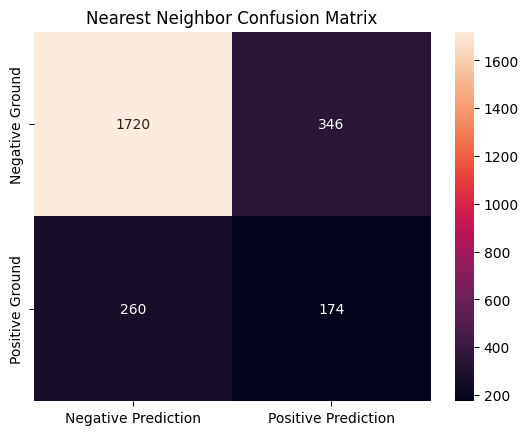

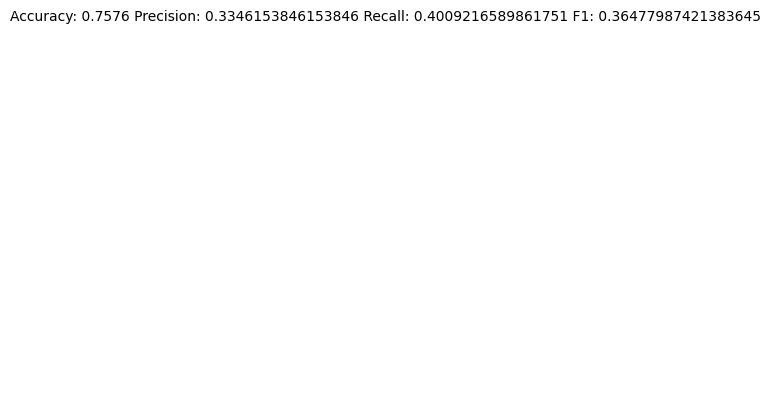

[]


In [113]:
print(best_model)


model_stats = {}
for k,v in best_model.items():
        model,sum = v
        predictions = model.predict(ft_test)
        matrix = confusion_matrix(predictions,label_test)
        tn,fp,fn,tp = matrix.ravel()
        metrics = compute_eval_metrics(tn,fp,fn,tp)
        model_stats[k]=(matrix,metrics)
print(model_stats)

plt.figure(figsize=(8, 5))

bars = plt.bar([name for name in best_model.keys()],[sum for id,sum in best_model.values()],color="Gray",label=f'Accuracy: {weights[0]}% Precision: {weights[1]}% Recall: {weights[2]}% F1: {weights[3]}%')
plt.title("Weighted Sum Per Model")
plt.xlabel("Model Name")
plt.ylabel("Weighted Sum")
plt.legend(loc='best')
bars[0].set_color('red')
plt.show()

all_metrics =[]
for k,v in model_stats.items():
  matrix,metrics = v
  curr_accuracy,curr_precision,curr_recall,curr_f1 = metrics
  sns.heatmap(matrix,fmt='g',annot=True,xticklabels=["Negative Prediction","Positive Prediction"],yticklabels=["Negative Ground","Positive Ground"])
  plt.title(f"{k} Confusion Matrix")

  eval_metrics = f'Accuracy: {curr_accuracy} Precision: {curr_precision} Recall: {curr_recall} F1: {curr_f1 }'

  plt.show()
  plt.text(0,1,eval_metrics)
  plt.axis('off')
  plt.show()


print(all_metrics)





In [114]:
with open('sample_data/README.md', 'r') as file:
    content = file.read()

print(content)

This directory includes a few sample datasets to get you started.

*   `california_housing_data*.csv` is California housing data from the 1990 US
    Census; more information is available at:
    https://docs.google.com/document/d/e/2PACX-1vRhYtsvc5eOR2FWNCwaBiKL6suIOrxJig8LcSBbmCbyYsayia_DvPOOBlXZ4CAlQ5nlDD8kTaIDRwrN/pub

*   `mnist_*.csv` is a small sample of the
    [MNIST database](https://en.wikipedia.org/wiki/MNIST_database), which is
    described at: http://yann.lecun.com/exdb/mnist/

*   `anscombe.json` contains a copy of
    [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet); it
    was originally described in

    Anscombe, F. J. (1973). 'Graphs in Statistical Analysis'. American
    Statistician. 27 (1): 17-21. JSTOR 2682899.

    and our copy was prepared by the
    [vega_datasets library](https://github.com/altair-viz/vega_datasets/blob/4f67bdaad10f45e3549984e17e1b3088c731503d/vega_datasets/_data/anscombe.json).

